In [1]:
pip install tf-keras pandas torch transformers scikit-learn ipywidgets sentence_transformers tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

In [3]:
# Load the dataset
df = pd.read_csv('ISOT40000.csv')  # Replace with your CSV file path
df = df.dropna(subset=['label'])
# Extract relevant columns
text_data = df['text'].fillna('').tolist()
title_data = df['title'].fillna('').tolist()
combined_data = [f"{title} {text}" for title, text in zip(title_data, text_data)]
labels = df['label'].tolist()

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
print(df['label'].value_counts())

label
0    20001
1    19999
Name: count, dtype: int64


In [4]:
# Define function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Pool to get a single embedding



In [5]:

model = SentenceTransformer('all-MiniLM-L6-v2')


# Get embeddings for each text
#embeddings = [get_bert_embedding(title) for title in title_data]

#embeddings = [get_bert_embedding(text) for text in tqdm(combined_data)]

text_temp, text_test, y_temp, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)
text_train, text_val, y_train, y_val = train_test_split(text_temp, y_temp, test_size=0.25, random_state=42)

embeddings_train = [model.encode(text) for text in tqdm(text_train, desc="Generating embeddings for training set")]
embeddings_val = [model.encode(text) for text in tqdm(text_val, desc="Generating embeddings for validation set")]
embeddings_test = [model.encode(text) for text in tqdm(text_test, desc="Generating embeddings for test set")]




Generating embeddings for training set:   0%|          | 0/24000 [00:00<?, ?it/s]

Generating embeddings for validation set:   0%|          | 0/8000 [00:00<?, ?it/s]

Generating embeddings for test set:   0%|          | 0/8000 [00:00<?, ?it/s]

In [6]:
from sklearn.metrics import confusion_matrix

import numpy as np

# Convert embeddings to numpy arrays for processing
X_train = np.array(embeddings_train)
X_val = np.array(embeddings_val)
X_test = np.array(embeddings_test)


# Scale embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Increase max_iter in LogisticRegression / Train a classifier
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = LogisticRegression(max_iter=500)  # Increase iterations

# Train an ensemble model
ensemble = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True))
], voting='soft')
ensemble.fit(X_train_scaled, y_train)

# Validate the model
y_val_pred = ensemble.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model
y_test_pred = ensemble.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))



Validation Accuracy: 97.95%
Test Accuracy: 97.59%

Confusion Matrix:
 [[3912  103]
 [  90 3895]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4015
           1       0.97      0.98      0.98      3985

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



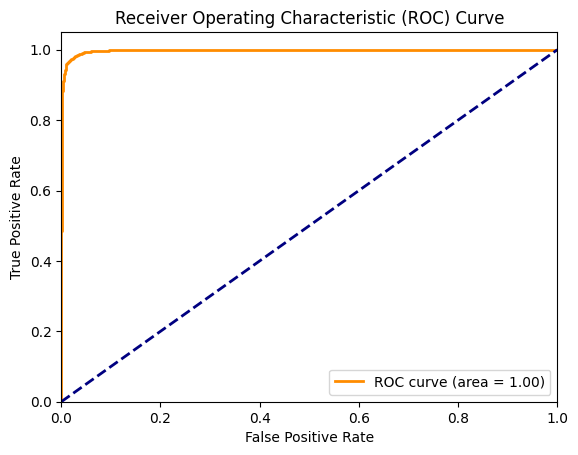

In [7]:


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
y_test_proba = ensemble.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class (label=1)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Add predictions to original dataframe
#df['prediction'] = ensemble.predict(embeddings)
#df['prediction'] = df['prediction'].apply(lambda x: 'real' if x == 1 else 'fake')

# Save results
df.to_csv('bert_isotcombined.csv', index=False)


In [8]:
import pandas as pd

# Save ROC curve data
roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_data.to_csv('roc_data_bert_isot.csv', index=False)

# Save ROC AUC
with open('roc_auc_bert_isot.txt', 'w') as f:
    f.write(str(roc_auc))
